# 서울시 평균 기온 예측 Baseline Code  

## 전체 과정
1. **데이터 불러오기**
   - `train.csv`와 `sample_submission.csv` 파일을 불러옵니다.
     - `train.csv` 파일에는 과거의 기상 데이터와 평균 기온이 포함되어 있습니다. 
     - `sample_submission.csv` 파일에는 예측할 날짜와 기온 예측값을 채워 넣을 형식이 포함되어 있습니다.  
2. **데이터 전처리**    
   - train_df의 일시 컬럼의 자료형을 datetime 으로 변경합니다.  
   - 일시 컬럼을 인덱스로 설정합니다.  
   - index의 freq 속성을 'D'로 변경합니다.  
3. **ARIMA 모델 설정 및 학습**
   - ARIMA 모델을 생성합니다.
   - train_df의 평균기온 컬럼을 사용하여 ARIMA 모델을 학습합니다.  
4. **예측 수행**
   - submission_df의 일시 컬럼의 자료형을 datetime으로 변경합니다.  
   - submission_df에서 일시 컬럼의 최솟값과 최댓값을 설정하여 시작날짜와 종료날짜를 지정합니다.  
   - 시작날짜와 종료날짜를 지정하여 기간에 대한 ARIMA 모델의 예측값을 반환받습니다.    
5. **결과 저장**
   - 학습된 모델을 사용하여 submission_df의 기간에 대한 평균기온을 예측합니다.    
   - 예측된 기온을 `sample_submission.csv` 파일 형식에 맞추어 저장합니다.
   - 저장된 파일은 `baseline_submit.csv`와 같은 형태로 제출할 수 있습니다.

# 1. 데이터 불러오기
- `train.csv` 파일은 다음과 같은 컬럼을 포함하고 있습니다.
    - 일시: 과거 데이터들의 관측 날짜 (1960-01-01 ~ 2022-12-31)
    - 최고기온, 최저기온, 일교차
    - 강수량, 평균습도, 평균풍속
    - 일조합, 일사합, 일조율
    - 평균기온: 우리가 예측하고자 하는 대상

    <br>
- `sample_submission.csv` 파일에는 다음과 같은 컬럼이 포함되어 있습니다.
    - 일시: 문제에서 정의된 미래에 대해 예측해야 할 날짜 (2023-01-01 ~ 2023-12-24)
    - 평균기온: 이 값에 대한 예측을 생성해야 합니다    
    
이번 베이스라인에서는 ARIMA 모델을 사용한 단변량예측을 수행합니다.    

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# 파일 경로
train_path = 'C:/Users/rlaal/OneDrive - UOU/2024-winter_semester/Dacon/Seoul_degree_preview/open/train.csv' # 학습 데이터 파일 경로
submission_path = 'C:/Users/rlaal/OneDrive - UOU/2024-winter_semester/Dacon/Seoul_degree_preview/open/sample_submission.csv' # 제출 양식 파일 경로

# 데이터 불러오기
train_df = pd.read_csv(train_path)
submission_df = pd.read_csv(submission_path)

display(train_df.head())
display(submission_df.head())

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


,일시,평균기온
0,2023-01-01,0
1,2023-01-02,0
2,2023-01-03,0
3,2023-01-04,0
4,2023-01-05,0


# 2. 데이터 전처리
- ARIMA 모델에 적합하도록 데이터를 가공합니다.

In [42]:
# 날짜 데이터 변환
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df = train_df.set_index('일시')

# 데이터의 시간 간격 지정
train_df.index.freq = 'D'

# 일시 컬럼이 인덱스로 할당됩니다.  
train_df.head()

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


# 2-1 결측치 제거

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23011 entries, 1960-01-01 to 2022-12-31
Freq: D
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   최고기온    23008 non-null  float64
 1   최저기온    23008 non-null  float64
 2   일교차     23007 non-null  float64
 3   강수량     9150 non-null   float64
 4   평균습도    23011 non-null  float64
 5   평균풍속    23007 non-null  float64
 6   일조합     22893 non-null  float64
 7   일사합     18149 non-null  float64
 8   일조율     22645 non-null  float64
 9   평균기온    23011 non-null  float64
dtypes: float64(10)
memory usage: 1.9 MB


In [44]:
train_df.isnull()
# 결측치 존재 True, 결측지 미존재 False

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1960-01-01,False,False,False,True,False,False,False,True,True,False
1960-01-02,False,False,False,False,False,False,False,True,True,False
1960-01-03,False,False,False,False,False,False,False,True,True,False
1960-01-04,False,False,False,False,False,False,False,True,True,False
1960-01-05,False,False,False,True,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,False,False,False,True,False,False,False,False,False,False
2022-12-28,False,False,False,False,False,False,False,False,False,False
2022-12-29,False,False,False,False,False,False,False,False,False,False


In [45]:
train_df.isnull().sum()
# 결측치 존재 True, 결측지 미존재 False

최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

강수량 null 값 많아서 탈락 --> 점수 영향 없음

In [36]:
train_df.drop(['강수량', '일사합'], axis = 1, inplace = True)

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23011 entries, 1960-01-01 to 2022-12-31
Freq: D
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   최고기온    23008 non-null  float64
 1   최저기온    23008 non-null  float64
 2   일교차     23007 non-null  float64
 3   평균습도    23011 non-null  float64
 4   평균풍속    23007 non-null  float64
 5   일조합     22893 non-null  float64
 6   일조율     22645 non-null  float64
 7   평균기온    23011 non-null  float64
dtypes: float64(8)
memory usage: 1.6 MB


# 2-2 EDA

heatmap

In [46]:
# 폰트 파일 경로
font_path = 'C:/Windows/Fonts/batang.ttc'
font_name = plt.matplotlib.font_manager.FontProperties(fname = font_path).get_name()

plt.rcParams['font.family'] = font_name

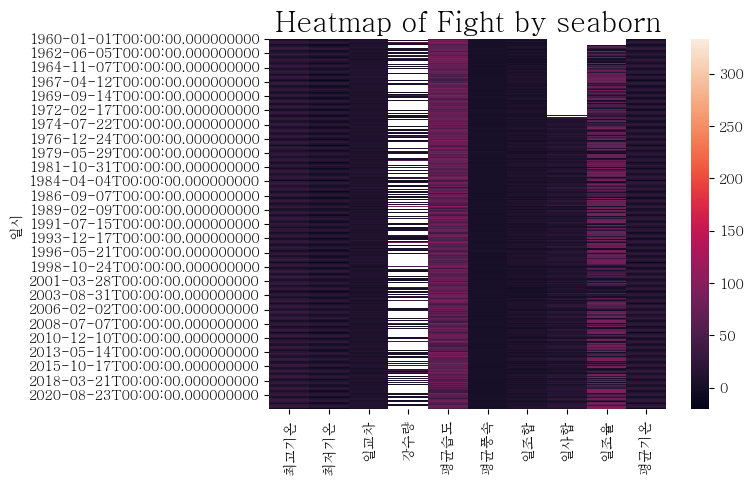

In [19]:
ax = sns.heatmap(train_df)
plt.title('Heatmap of Fight by seaborn', fontsize = 20)
plt.show()

In [47]:
# 계절성 확인을 위해 년도, 월, 일 칼럼 생성
train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month
train_df['day'] = train_df.index.day

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62],
 [Text(0, 0, '1960'),
  Text(1, 0, '1961'),
  Text(2, 0, '1962'),
  Text(3, 0, '1963'),
  Text(4, 0, '1964'),
  Text(5, 0, '1965'),
  Text(6, 0, '1966'),
  Text(7, 0, '1967'),
  Text(8, 0, '1968'),
  Text(9, 0, '1969'),
  Text(10, 0, '1970'),
  Text(11, 0, '1971'),
  Text(12, 0, '1972'),
  Text(13, 0, '1973'),
  Text(14, 0, '1974'),
  Text(15, 0, '1975'),
  Text(16, 0, '1976'),
  Text(17, 0, '1977'),
  Text(18, 0, '1978'),
  Text(19, 0, '1979'),
  Text(20, 0, '1980'),
  Text(21, 0, '1981'),
  Text(22, 0, '1982'),
  Text(23, 0, '1983'),
  Text(24, 0, '1984'),
  Text(25, 0, '1985'),
  Text(26, 0, '1986'),
  Text(27, 0, '1987'

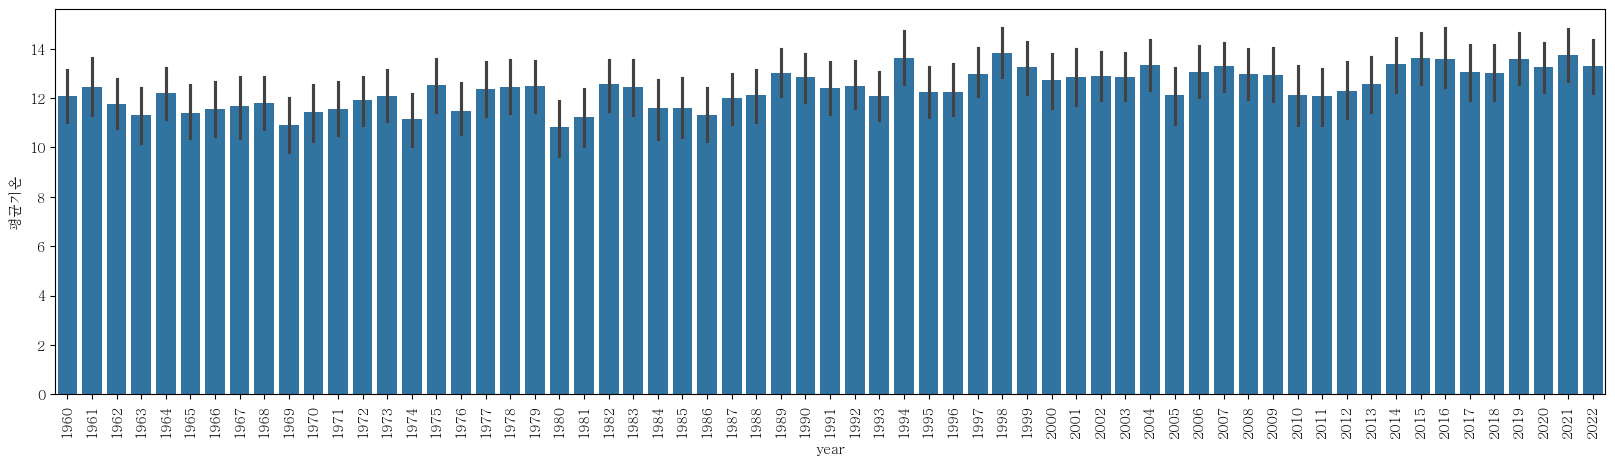

In [9]:
plt.figure(figsize = (20, 5))
sns.barplot(data = train_df, x = 'year', y = '평균기온')
plt.xticks(rotation=90)


크게 튀는 값 없이 값이 일정하다

## 연도별 월  데이터

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62],
 [Text(0, 0, '1960'),
  Text(1, 0, '1961'),
  Text(2, 0, '1962'),
  Text(3, 0, '1963'),
  Text(4, 0, '1964'),
  Text(5, 0, '1965'),
  Text(6, 0, '1966'),
  Text(7, 0, '1967'),
  Text(8, 0, '1968'),
  Text(9, 0, '1969'),
  Text(10, 0, '1970'),
  Text(11, 0, '1971'),
  Text(12, 0, '1972'),
  Text(13, 0, '1973'),
  Text(14, 0, '1974'),
  Text(15, 0, '1975'),
  Text(16, 0, '1976'),
  Text(17, 0, '1977'),
  Text(18, 0, '1978'),
  Text(19, 0, '1979'),
  Text(20, 0, '1980'),
  Text(21, 0, '1981'),
  Text(22, 0, '1982'),
  Text(23, 0, '1983'),
  Text(24, 0, '1984'),
  Text(25, 0, '1985'),
  Text(26, 0, '1986'),
  Text(27, 0, '1987'

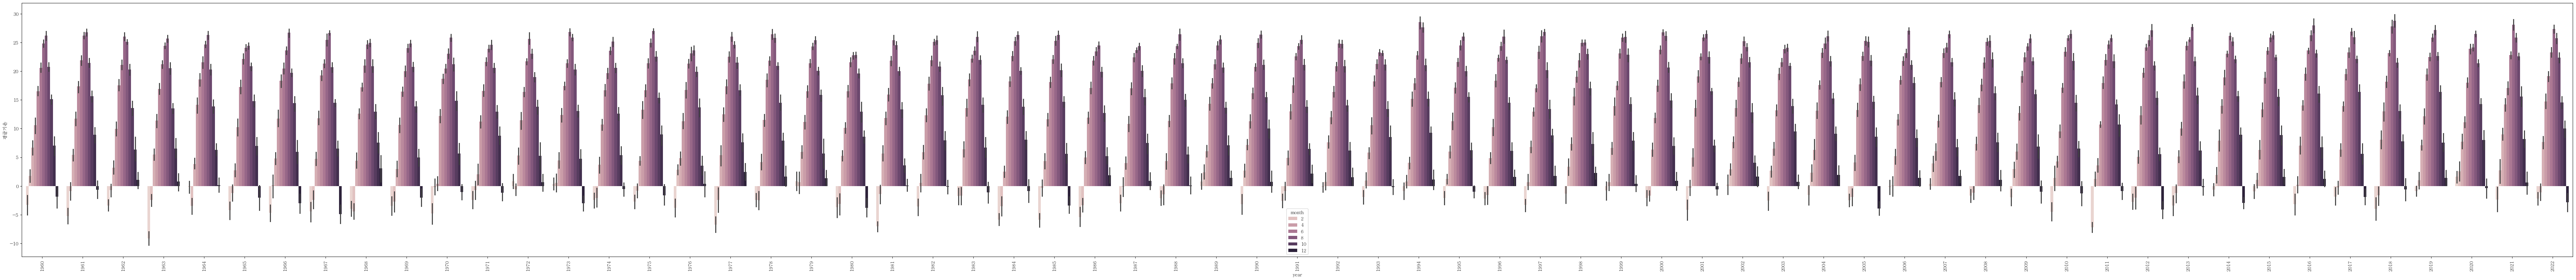

In [48]:
plt.figure(figsize = (100, 10))
sns.barplot(data = train_df, x = 'year', y = '평균기온', hue = 'month')
plt.xticks(rotation=90)

## 월별 데이터

<Axes: xlabel='month', ylabel='평균기온'>

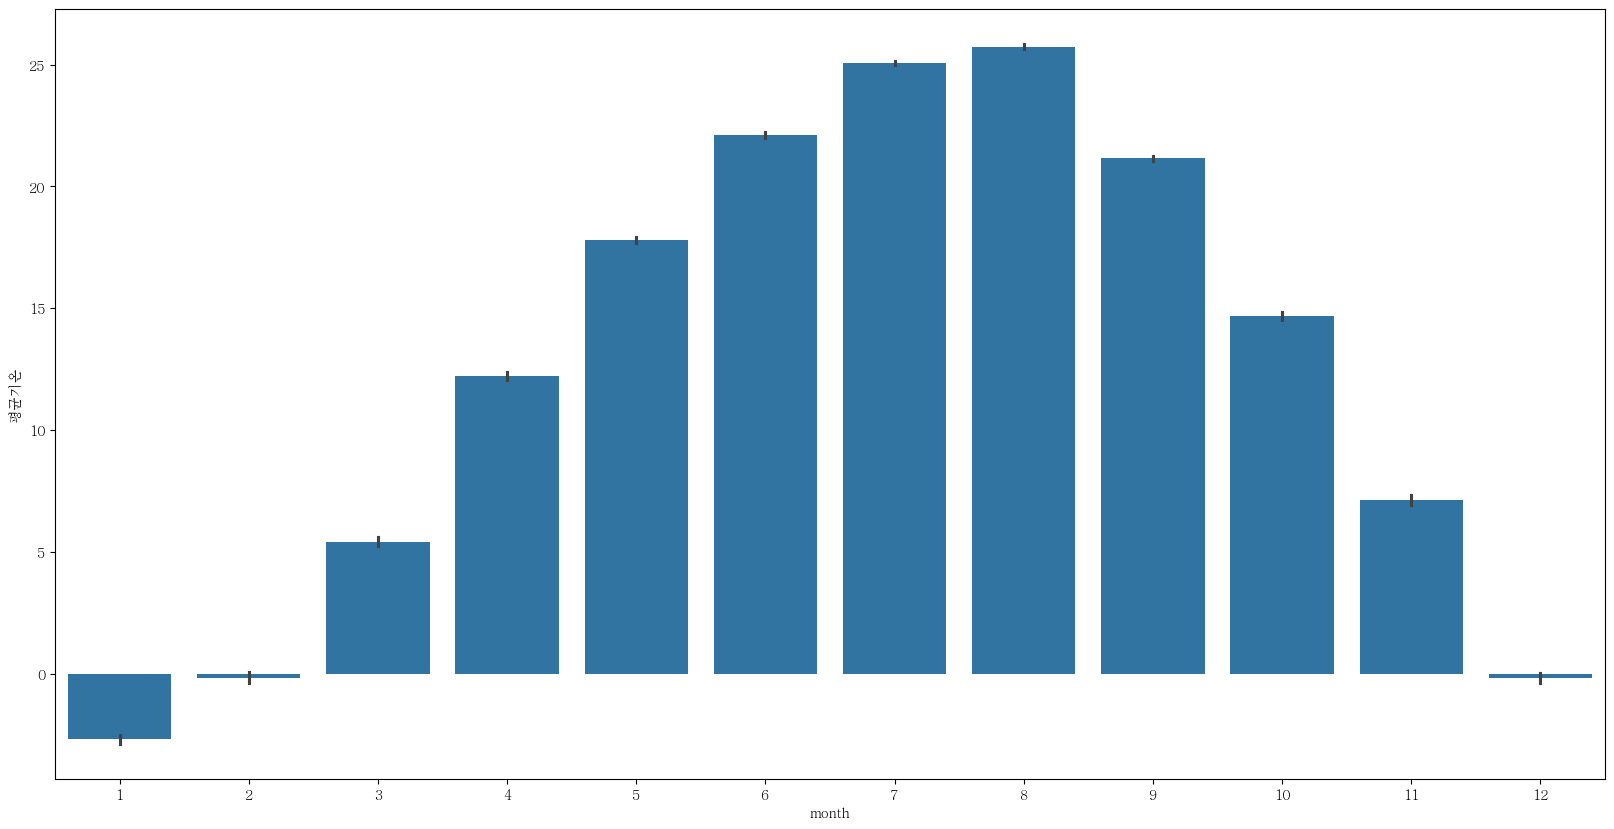

In [40]:
plt.figure(figsize = (20,10))
sns.barplot(data = train_df, x = 'month', y = '평균기온')

6, 7, 8, 9 = 여름    
12, 1, 2 = 겨율  
3, 4, 5, 10, 11 = 간절기

## 월별 연도별 평균기온

<Axes: xlabel='month', ylabel='평균기온'>

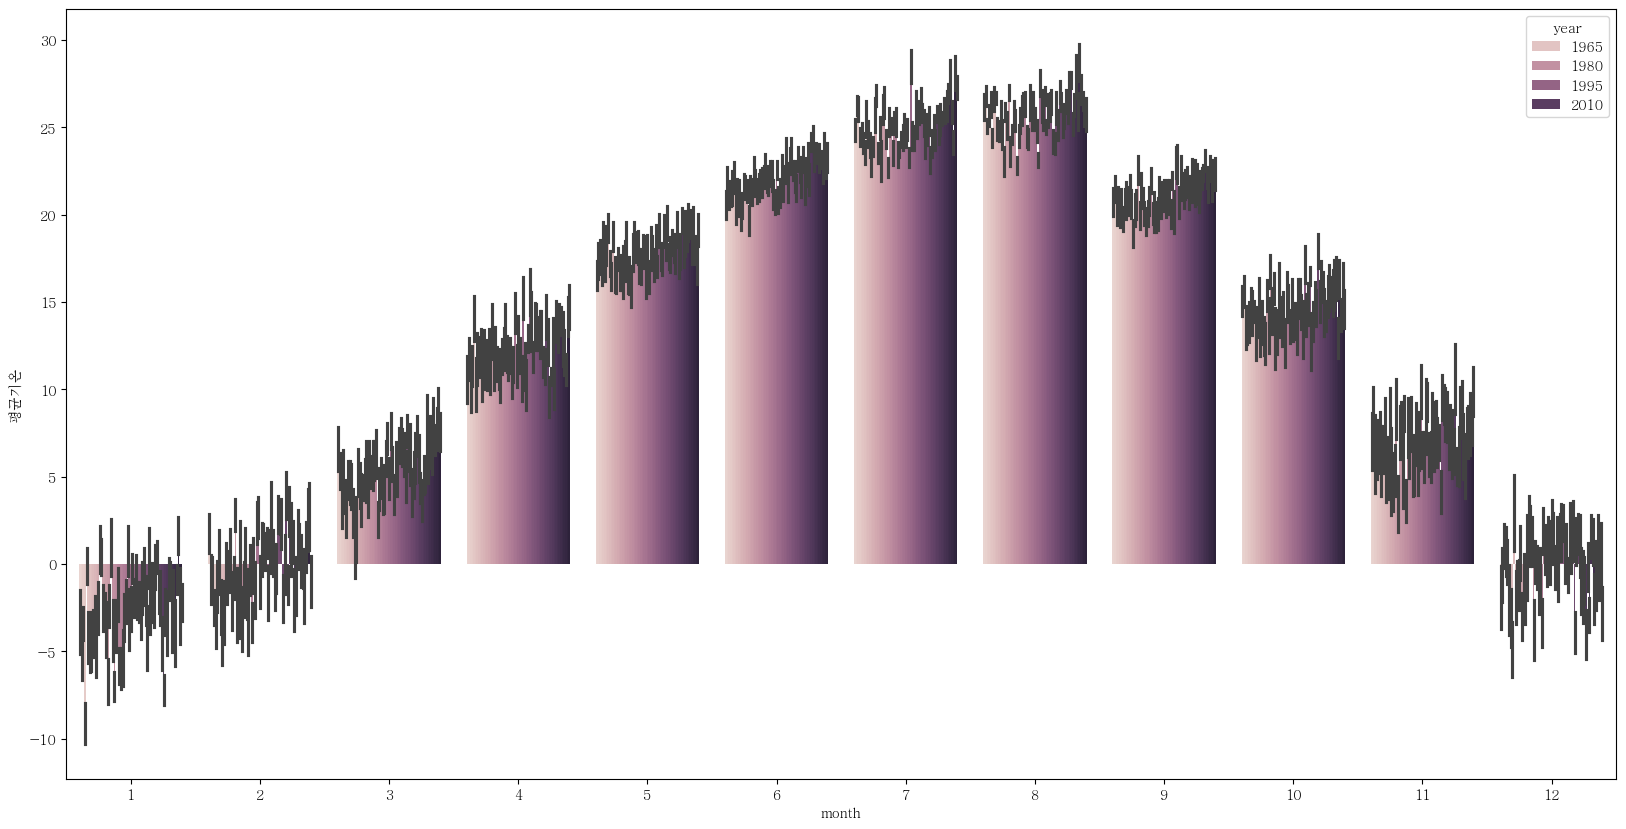

In [42]:
plt.figure(figsize = (20,10))
sns.barplot(data = train_df, x = 'month', y = '평균기온', hue = 'year')

12월 1월 2월 아 차이가 많이 난다

## 연도별 그래프

(array([1950., 1960., 1970., 1980., 1990., 2000., 2010., 2020., 2030.]),
 [Text(1950.0, 0, '1950'),
  Text(1960.0, 0, '1960'),
  Text(1970.0, 0, '1970'),
  Text(1980.0, 0, '1980'),
  Text(1990.0, 0, '1990'),
  Text(2000.0, 0, '2000'),
  Text(2010.0, 0, '2010'),
  Text(2020.0, 0, '2020'),
  Text(2030.0, 0, '2030')])

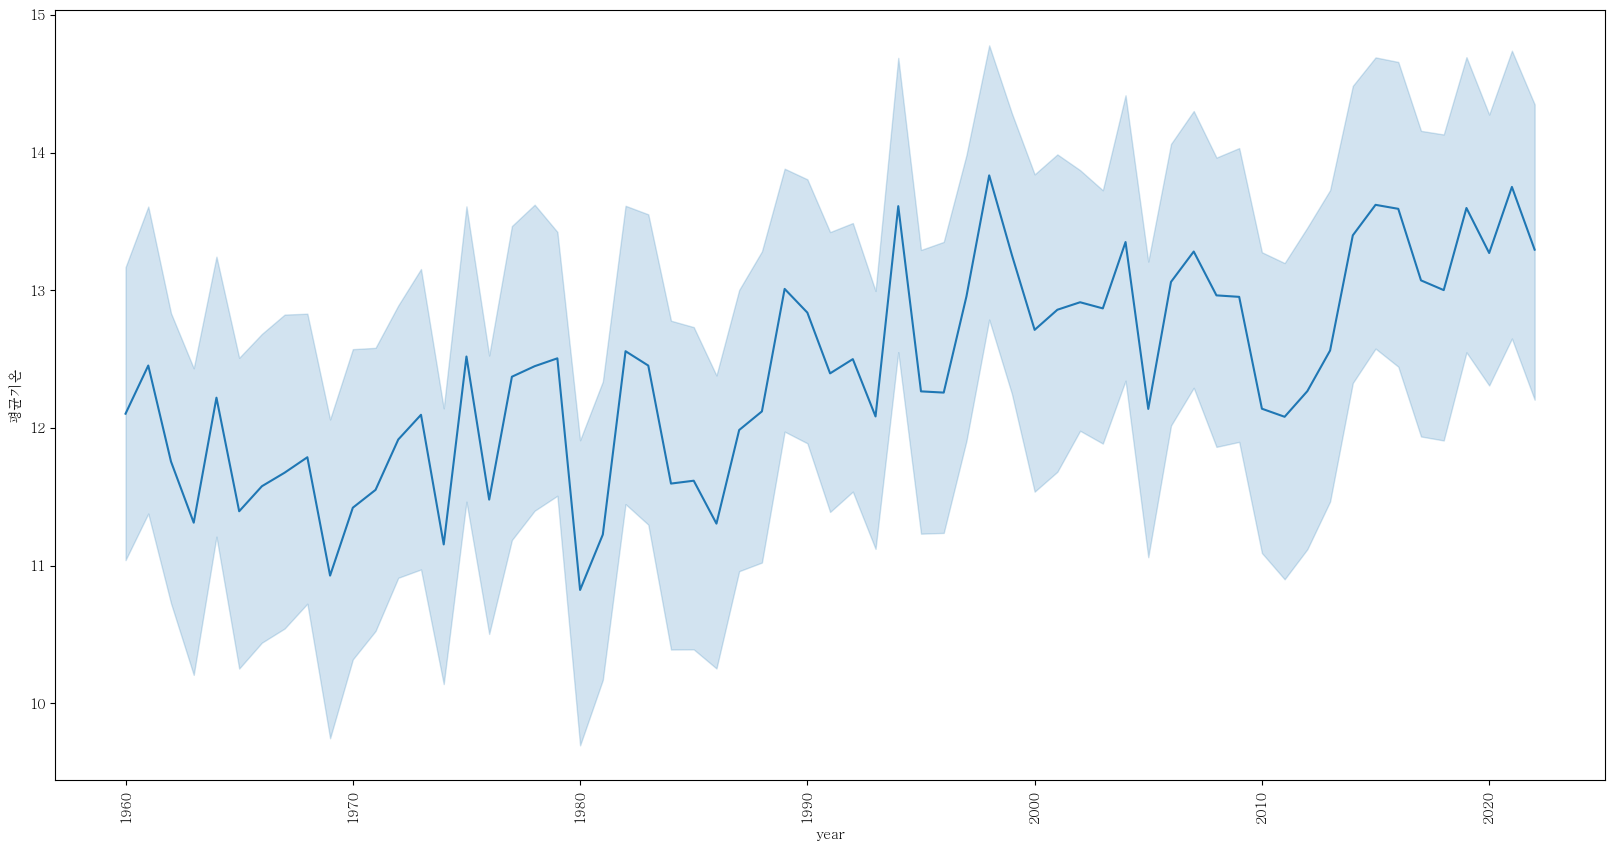

In [43]:
plt.figure(figsize = (20,10))
sns.lineplot(data = train_df, x = 'year', y = '평균기온')
plt.xticks(rotation=90)

전체적인 기온이 올라가고 있음

## 연도별 월 평균기온 데이터

(array([1950., 1960., 1970., 1980., 1990., 2000., 2010., 2020., 2030.]),
 [Text(1950.0, 0, '1950'),
  Text(1960.0, 0, '1960'),
  Text(1970.0, 0, '1970'),
  Text(1980.0, 0, '1980'),
  Text(1990.0, 0, '1990'),
  Text(2000.0, 0, '2000'),
  Text(2010.0, 0, '2010'),
  Text(2020.0, 0, '2020'),
  Text(2030.0, 0, '2030')])

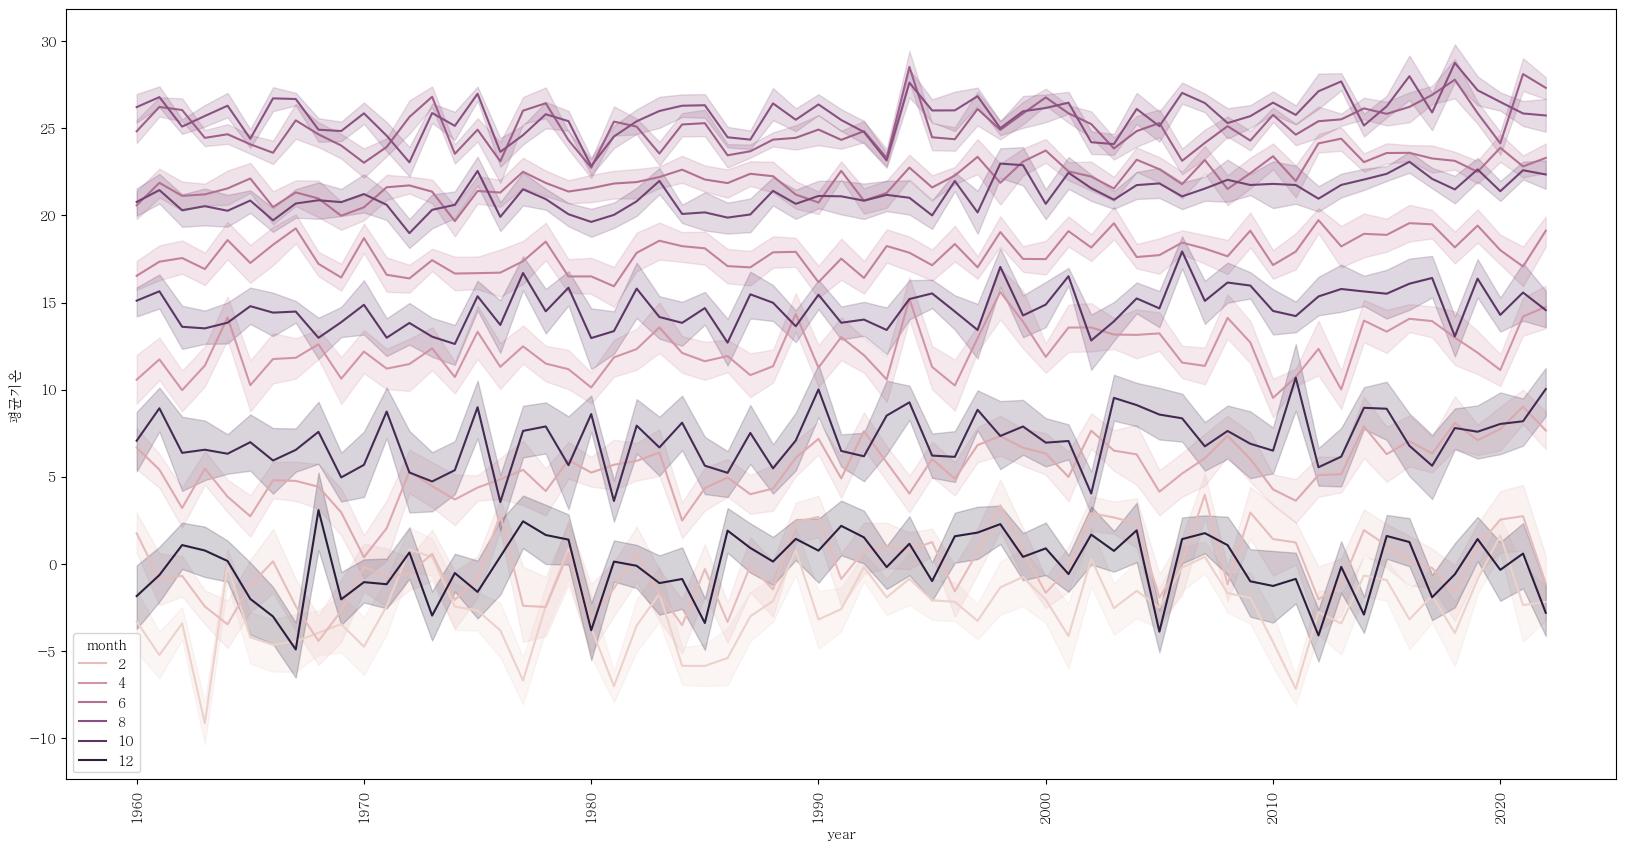

In [44]:
plt.figure(figsize = (20,10))
sns.lineplot(data = train_df, x = 'year', y = '평균기온', hue = 'month')
plt.xticks(rotation=90)

<Axes: xlabel='month', ylabel='평균기온'>

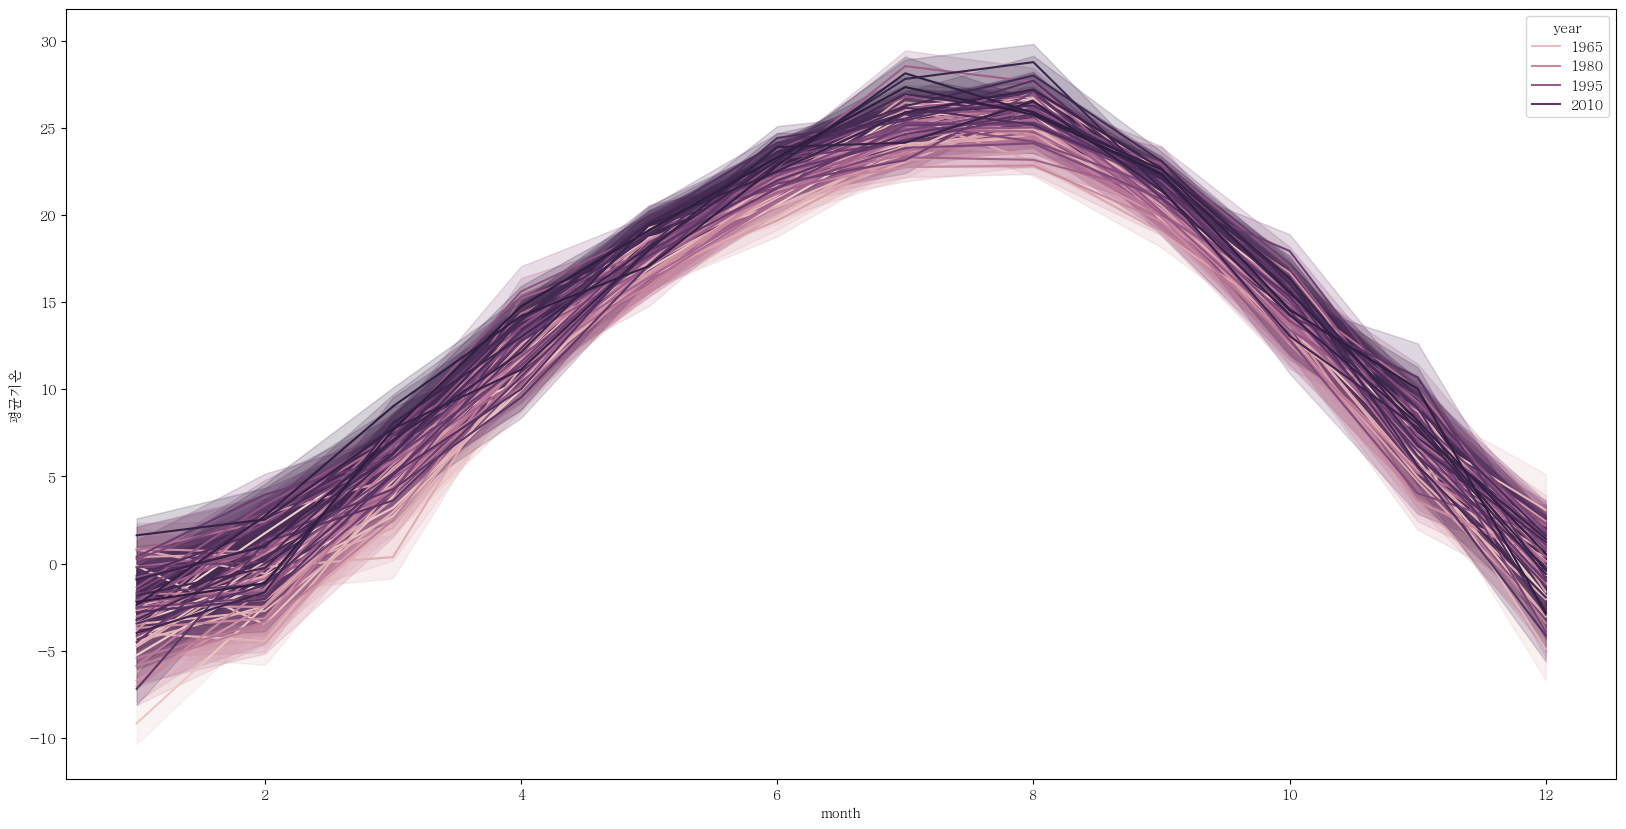

In [50]:
plt.figure(figsize = (20,10))
sns.lineplot(data = train_df, x = 'month', y = '평균기온', hue = 'year')

확실하게 정규분포 비슷한 경향성을 보인다  
6, 7, 8 이 큰

# 3. ARIMA 모델 설정 및 학습
- ARIMA 모델을 생성하고, 학습 데이터로 모델을 학습합니다.
- ARIMA 모델은 시계열 데이터 분석에 사용하는 통계적 모델 중 하나로,    
정상성을 충족시키면서 적절한 파라미터를 선택할 경우 좋은 성능을 보입니다.    

d 의 최적화

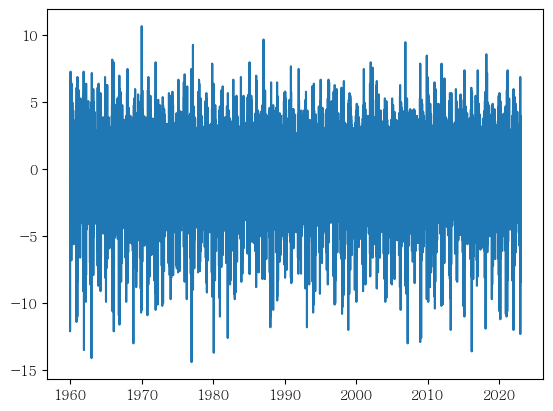

In [51]:
diff_1 = train_df['평균기온'].diff().dropna()
plt.plot(diff_1)
plt.show()

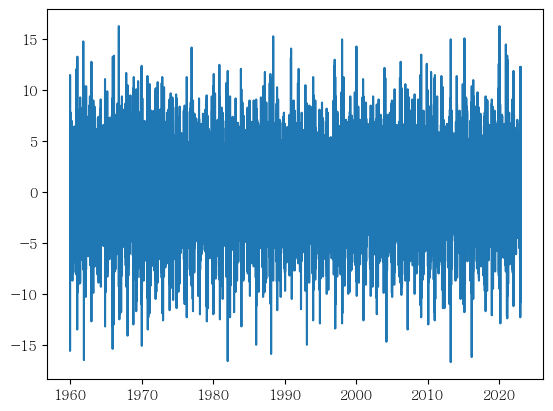

In [52]:
diff_2 = diff_1.diff().dropna()
plt.plot(diff_2)
plt.show()

In [53]:
pip install pmdarima


  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/cf/1c/83b87c760144281f0dc4df43578587b59fe3c38f9d660b575adb9480a11a/pmdarima-2.0.4-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=0.11 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/d1/c8/66df3e941bfa29a1b00f79d5a62af8df3556488b69ca71b3a314a1331bb7/Cython-3.0.7-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for scikit-learn>=0.22 from https://files.pythonhosted.org/packages/fe/6b/db949ed5ac367987b1f250f070f340b7715d22f0c9c965bdf07de6ca75a3/scikit_learn-1.3.2-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for urllib3 from https://files.pythonhosted.org/packages/96/94/c31f58c7a7f470d5665935262ebd7455


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
import pmdarima as pm

kpss_diffs = pm.arima.ndiffs(train_df['평균기온'], alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train_df['평균기온'], alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 1


In [60]:
# 직접 지정해주어 모델링 실시
model = pm.auto_arima(y=train_df['평균기온'],		# 데이터
                      d=n_diffs,	# 차분 (d), 기본값 = None
                      start_p= 0,	# 시작 p값, 기본값 = 2
                      max_p = 5,	# p 최대값, 기본값 = 5
                      start_q= 0,	# 시작 q값, 기본값 = 2
                      max_q = 5,	# q 최대값, 기본값 = 5
                      m=1,			# season의 주기, 기본값 = 1
                      seasonal=False,	# sARIMA를 실시, 기본값 = True
                      stepwise=True,	# stepwise algorithm, 기본값 = True
                      trace=True)		# 각 step을 출력할지, 기본값 = False

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105052.236, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104897.100, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104747.577, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105050.236, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=104328.023, Time=2.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=101906.995, Time=3.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=103178.596, Time=0.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=101855.343, Time=6.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=102845.972, Time=1.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=101819.100, Time=6.95 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=102442.831, Time=2.05 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=101820.352, Time=8.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=101476.210, Time=20.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=101830.449, Time=6.19 sec
 ARI

In [61]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델 훈련

# model = ARIMA(train_df['평균기온'], order=(4, 1, 2))  # p, d, q 값은 조정 필요
model_fit = model.fit()

TypeError: ARIMA.fit() missing 1 required positional argument: 'y'

# 4. 예측 수행
- 학습된 모델을 사용하여 미래 기온을 예측합니다.

In [58]:
submission_df['일시'] = pd.to_datetime(submission_df['일시'])

# 예측할 기간 설정
start_date = submission_df['일시'].min()
end_date = submission_df['일시'].max()

# ARIMA 모델을 사용하여 예측
forecast = model_fit.predict(start=start_date, end=end_date, typ='levels')

c:\Users\rlaal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


예측 시각화

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


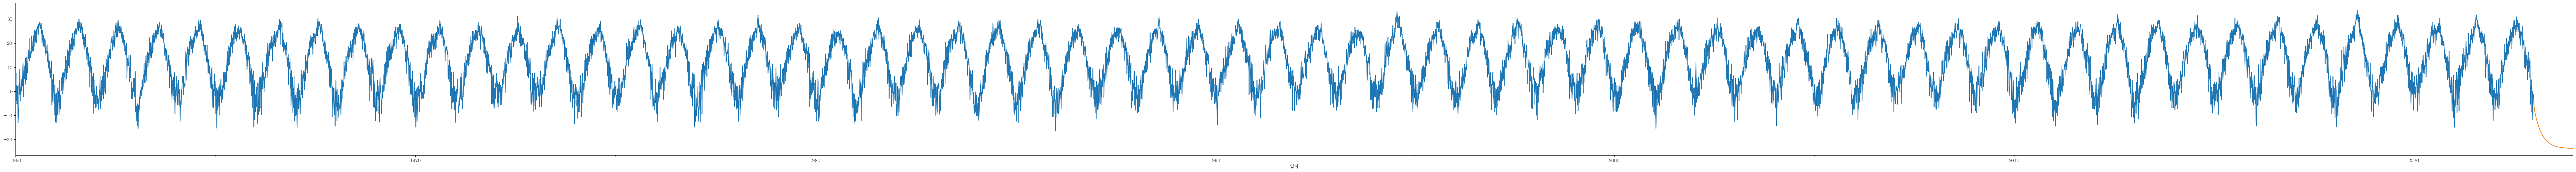

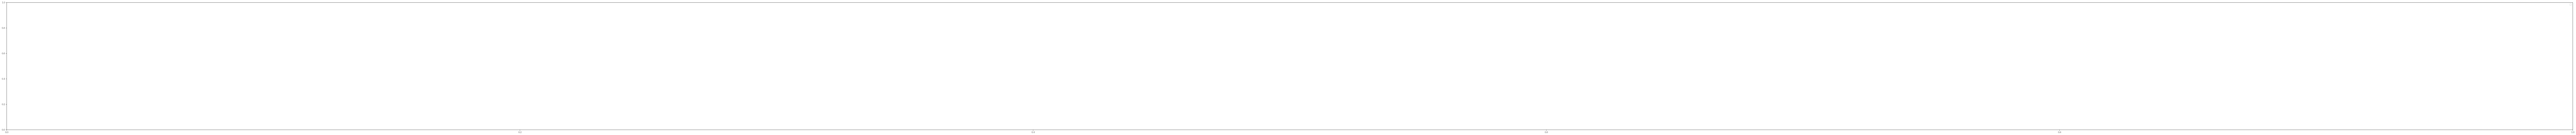

In [69]:

# 데이터의 시간 간격 지정
submission_df.index.freq = 'D'

plt.figure(figsize=(100, 6))
# 일시 컬럼이 인덱스로 할당됩니다.  
train_df.head()
train_df['평균기온'].plot(label='Train')
submission_df['평균기온'].plot(label='Predict')
plt.figure(figsize=(200, 10))  # 원하는 크기로 대체
plt.legend()
plt.show()

올라갔다 내려갔다가 있어야 하는데 같은 경향성이 보이지 않음 모델 최적화를 바꾸자

# 5. 예측 결과 저장
- 예측된 결과를 sample_submission.csv 파일 형식에 맞추어 저장합니다.

In [ ]:
# 예측 결과 추출 및 확인
submission_df['평균기온'] = forecast.values
display(submission_df.head())

# 예측 결과 저장
submission_df.to_csv('C:/Users/rlaal/OneDrive - UOU/2024-winter_semester/Dacon/Seoul_degree_preview/Submission/submission_2023_12_26_4.csv', index=False)

,일시,평균기온
0,2023-01-01,-2.907890
1,2023-01-02,-4.674438
2,2023-01-03,-5.743211
3,2023-01-04,-6.373306
4,2023-01-05,-6.841716
